In [ ]:
import torch
import numpy as np
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


In [ ]:
import gdown
import pandas as pd

# -------- Train --------
train_id = "1GKQt7iAbiMfwWMyNXXTkO8WCRA6XdeJgqP9ip1koeQo"
train_file = "train.xlsx"
train_url = f"https://docs.google.com/spreadsheets/d/{train_id}/export?format=xlsx"

gdown.download(train_url, train_file, quiet=False)
train_df = pd.read_excel(train_file)


# -------- Validation --------
val_id = "1JIrWLlWDgKeWjkfHpnlayNAiLinS-TcRmL2oSp4oZsQ"
val_file = "validation.xlsx"
val_url = f"https://docs.google.com/spreadsheets/d/{val_id}/export?format=xlsx"

gdown.download(val_url, val_file, quiet=False)
val_df = pd.read_excel(val_file)


# -------- Test --------
test_id = "1COiSxsK0HKbhLHM-up2UZngZ_neZV7OwZbZJjOw6M4g"
test_file = "test.xlsx"
test_url = f"https://docs.google.com/spreadsheets/d/{test_id}/export?format=xlsx"

gdown.download(test_url, test_file, quiet=False)
test_df = pd.read_excel(test_file)


train_df.head(), val_df.head(), test_df.head()


/usr/local/lib/python3.12/dist-packages/gdown/parse_url.py:48: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  warnings.warn(
Downloading...
From: https://docs.google.com/spreadsheets/d/1GKQt7iAbiMfwWMyNXXTkO8WCRA6XdeJgqP9ip1koeQo/export?format=xlsx
To: /content/train.xlsx
475kB [00:00, 641kB/s]
/usr/local/lib/python3.12/dist-packages/gdown/parse_url.py:48: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  warnings.warn(
Downloading...
From: https://docs.google.com/spreadsheets/d/1JIrWLlWDgKeWjkfHpnlayNAiLinS-TcRmL2oSp4oZsQ/export?format=xlsx
To: /content/validation.xlsx
122kB [00:00, 288kB/s]
/usr/local/lib/python3.12/dist-packages/gdown/parse_url.py:48: UserWarning: You specified a Google Drive li

(                                                text  label
 0  এই গেরুয়া হিন্দুদের জন্য একজন সাধারণ হিন্দু হি...      0
 1  একটা উপদেশঃ আন্দোলন চালিয়ে যান,,,যতক্ষন না পর্...      0
 2  বাংলাদেশে ধর্মীয় ইস্যুতে কোন হিন্দুর বিচার কী ...      0
 3  স্কুল কলেজ ইউনিভার্সিটি39তে সরস্বতী পূজা হতে প...      0
 4  আমাদের দেশে পুলিশ এত ক্ষমতা পায় কোথায় থেকে এর...      0,
                                                 text  label
 0  চিটার বাটপার বাটপার সব সময় টিভি কালকে সারা দি...      1
 1  যেদিন বাঘের নাম বাদ দিয়ে বন বিড়াল রাখা হবে সেদ...      1
 2          পহেলা বৈশাখের তিন ধাপের নিরাপত্তা কোথায়?      0
 3  ব্যবসাহিক রা আসলে একটু বেশি বাটপার বেশি বাড়াব...      1
 4  ভাগ্যিস মানুষের ঘরে জন্ম নিয়েছি, আওয়ামী লীগের ...      0,
                                                 text  label
 0          যারা মারছে তাদের বিচার হোক ফোটেজ দেখে হোক      0
 1                       ভুট তুদের পিচন দিয়ে দেয়া হবে      2
 2  ষড়যন্ত্রকারীরা কত শক্তিশালী! অঘটন ঘটানোর জন্য...      0
 3  এরকম শিক্ষা প্রথিস

In [ ]:
MODEL_NAME = "FacebookAI/xlm-roberta-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# create dataset classes

MAX_LEN = 192  # max token length for Bangla sentences

class ViolenceDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=MAX_LEN):
        self.texts = df['text'].tolist()
        self.labels = df['label'].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
            add_special_tokens=True
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create dataset objects
train_dataset = ViolenceDataset(train_df, tokenizer)
val_dataset = ViolenceDataset(val_df, tokenizer)

In [ ]:
# Compute class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)

class_weights = torch.tensor(class_weights, dtype=torch.float)

In [ ]:
# Define compute_metrics function

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "precision_macro": precision_score(labels, preds, average="macro", zero_division=0),
        "recall_macro": recall_score(labels, preds, average="macro", zero_division=0),
    }

In [ ]:
# Define TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,  # Increased to 10 (common in Bangla classification papers; XLM-R often benefits from longer training)
    max_steps=-1,

    learning_rate=1e-5,  # Lower LR (1e-5) is frequently reported as optimal for XLM-RoBERTa fine-tuning on Bangla tasks
    weight_decay=0.01,  # Standard value; kept moderate to prevent overfitting
    warmup_ratio=0.06,  # Common default (~6% warmup); adjusts to longer epochs

    per_device_train_batch_size=16,  # Increased to 16 (effective batch ~32 with accumulation); better gradient stability for XLM-R
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,

    eval_strategy="steps",
    eval_steps=200,

    logging_strategy="steps",
    logging_steps=20,
    logging_first_step=True,

    save_strategy="steps",
    save_steps=200,
    save_total_limit=2,

    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,

    fp16=torch.cuda.is_available(),
    max_grad_norm=1.0,

    report_to="none",
    disable_tqdm=False,
)

In [ ]:
# Custom loss with class weights

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels").long()
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fn = CrossEntropyLoss(
            weight=class_weights.to(logits.device)
        )
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [ ]:
# Initialize Trainer

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-1537399394.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
200,0.968400,0.851220,0.649162,0.650570,0.664627,0.663196
400,0.703800,0.690980,0.692179,0.694382,0.699319,0.716294
600,0.583900,0.663782,0.736872,0.736474,0.731896,0.744212
800,0.502700,0.654970,0.762570,0.759731,0.756510,0.766500
1000,0.491800,0.619389,0.760335,0.758817,0.755305,0.763417
1200,0.427900,0.626488,0.772626,0.772051,0.770459,0.775050
1400,0.379000,0.592247,0.779330,0.778039,0.772936,0.787399
1600,0.340000,0.638036,0.779330,0.777834,0.774362,0.783643
1800,0.356800,0.640978,0.794413,0.792729,0.790408,0.795631
2000,0.283200,0.669907,0.792179,0.788401,0.785379,0.792798


TrainOutput(global_step=2620, training_loss=0.48568830089714693, metrics={'train_runtime': 1875.2508, 'train_samples_per_second': 44.543, 'train_steps_per_second': 1.397, 'total_flos': 8241698918557440.0, 'train_loss': 0.48568830089714693, 'epoch': 10.0})

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

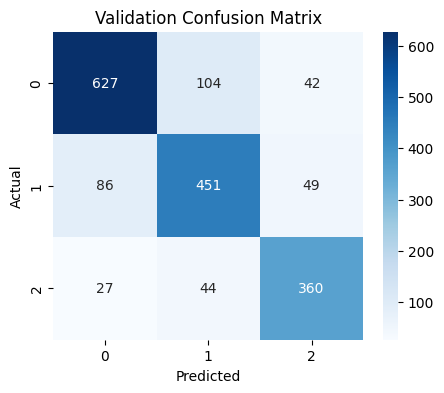

In [ ]:
# Get validation predictions
val_predictions = trainer.predict(val_dataset)
val_preds = np.argmax(val_predictions.predictions, axis=1)
val_labels = val_predictions.label_ids

# Compute confusion matrix
cm_val = confusion_matrix(val_labels, val_preds)

# Display
plt.figure(figsize=(5,4))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Validation Confusion Matrix')
plt.show()

In [ ]:
# convert test data

test_dataset = ViolenceDataset(test_df, tokenizer)

In [ ]:
# Get predictions from the trained model

predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

In [ ]:
# Add a new column for predicted labels
test_df['predicted_label'] = preds

# Save to CSV
test_df.to_csv("bangla_violence_test_predictions.csv", index=False)

# Check first few rows
print(test_df.head())

In [ ]:

from sklearn.metrics import classification_report

predictions = trainer.predict(test_dataset)

y_pred = np.argmax(predictions.predictions, axis=1)

y_true = predictions.label_ids


In [ ]:
print(
    classification_report(
        y_true,
        y_pred,
        target_names=["class_0", "class_1", "class_2"],
        digits=2
    )
)


              precision    recall  f1-score   support

     class_0       0.83      0.80      0.82       773
     class_1       0.75      0.77      0.76       586
     class_2       0.80      0.81      0.80       431

    accuracy                           0.79      1790
   macro avg       0.79      0.79      0.79      1790
weighted avg       0.79      0.79      0.79      1790



In [ ]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.6622434258460999, 'eval_accuracy': 0.8033519553072626, 'eval_f1_macro': 0.8021082950792796, 'eval_precision_macro': 0.7994816657567584, 'eval_recall_macro': 0.8053389599491484, 'eval_runtime': 4.5899, 'eval_samples_per_second': 389.985, 'eval_steps_per_second': 12.201, 'epoch': 10.0}


In [ ]:
# Confusion Matrix

if 'label' in test_df.columns:
    test_labels = test_df['label'].values
    cm_test = confusion_matrix(test_labels, preds)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Test Confusion Matrix')
    plt.show()
else:
    print("No true labels in test set; cannot compute confusion matrix for test data.")